### Old codeing

In [2]:
# Import necessary libraries
import os, re, time, urllib.parse, urllib.request, gzip, json
from collections import defaultdict, Counter

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import seaborn as sns
import statistics
import csv

#from sklearn.feature_extraction.text import TfidfVectorizer

from adjustText import adjust_text


In [ ]:
# ==========  BUILD BIPARTITE GRAPH ==========

# Load data
df = pd.read_csv("festival_artist_data.csv")

G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    festival_node = row['Festival_Year']
    artist_node = row['Artist_Name']
        # --- Extract festival name + year ---

    parts = festival_node.split("-")

    festival_name = parts[0]          # always first element
    year_str = parts[-1]              # always last element

    # --- Add festival-year node with attributes ---
    G.add_node(
        festival_node,
        bipartite="festival_year",
        festival=festival_name,
        year=year_str    
        )

    G.add_node(artist_node, bipartite="artist")

    G.add_edge(festival_node, artist_node)


# Convert graph to JSON serializable structure
data = json_graph.node_link_data(G)

with open("festival_network.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("Saved 'festival_network.json'")

FileNotFoundError: [Errno 2] No such file or directory: 'festival_artist_data.csv'

In [ ]:
artist_nodes = [
    n for n, d in G.nodes(data=True)
    if d.get("bipartite") == "artist"]

In [10]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode())

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)
print("Loaded graph with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")


Loaded graph with 7404 nodes and 12095 edges


### basic analysis for bipartie

In [11]:
#basic analysis

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()


festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']
artist_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']

print("Total nodes:", num_nodes)
print("Total edges:", num_edges)
print("Festival-Year nodes:", len(festival_nodes))
print("Artist nodes:", len(artist_nodes))


Total nodes: 7404
Total edges: 12095
Festival-Year nodes: 317
Artist nodes: 7087


In [12]:
artist_degrees = [G.degree(n) for n in artist_nodes]
festival_degrees = [G.degree(n) for n in festival_nodes]

print("Average artists per festival:", sum(festival_degrees) / len(festival_degrees))
print("Average festivals per artist:", sum(artist_degrees) / len(artist_degrees))

Average artists per festival: 38.154574132492115
Average festivals per artist: 1.7066459714971074


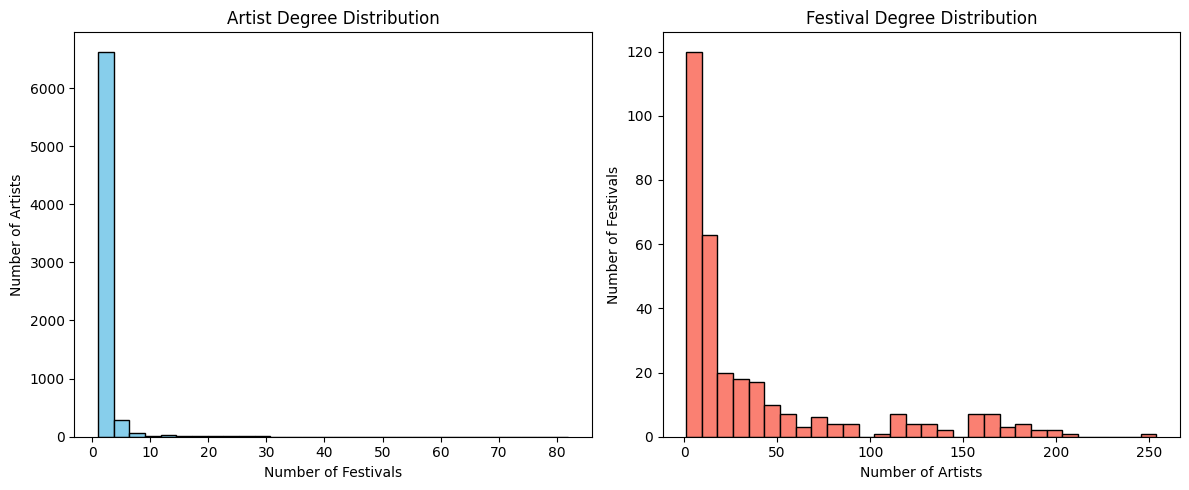

In [13]:
# plot degree distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(artist_degrees, bins=30, color='skyblue', edgecolor='black')
plt.title('Artist Degree Distribution')
plt.xlabel('Number of Festivals')
plt.ylabel('Number of Artists') 
plt.subplot(1, 2, 2)
plt.hist(festival_degrees, bins=30, color='salmon', edgecolor='black')
plt.title('Festival Degree Distribution')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Festivals')
plt.tight_layout()
plt.show()

In [15]:
components = list(nx.connected_components(G))
print("Number of connected components:", len(components))

Number of connected components: 8


In [16]:
#print each connected component sizes
for i, component in enumerate(components):
    print(f"Component {i+1} size: {len(component)}")

Component 1 size: 7387
Component 2 size: 3
Component 3 size: 2
Component 4 size: 2
Component 5 size: 3
Component 6 size: 2
Component 7 size: 3
Component 8 size: 2


In [ ]:
# print what is included in components[i] where i goes from 2 to 8.
for i in range(1, 8):
    for node in components[i]:
        print("Component {i} includes node:{node}")

diana-krall
copenhagen-jazz-festival-2000
tony-bennett
baryl
copenhagen-jazz-festival-2024
copenhagen-jazz-festival-2006
sérgio-mendes
gwyneth-herbert
nikolaj-nørlund
copenhagen-jazz-festival-2005
groen-koncert-1984
nanna-luders-jensen
groen-koncert-2015
christopher-singer
lagsus-with-emil-stabil-cisilia-vild-smith
lagsus-with-gilli-rapper
groen-koncert-2016


In [ ]:
# copy of network and only save largest components
G_orginal = G.copy()
largest_component = max(components, key=len)
G = G_orginal.subgraph(largest_component).copy()

In [19]:
nx.shortest_path_length(G, source=festival_nodes[0])

if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print("Average shortest path length:", avg_path)
else:
    print("Graph is not connected; average shortest path length is undefined.")



KeyboardInterrupt: 

Average shortest path length: 4.552057498424406


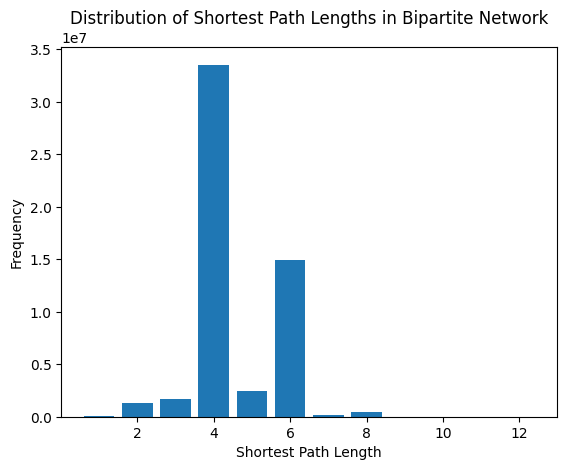

In [49]:
nx.shortest_path_length(G, source=festival_nodes[0])

if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print("Average shortest path length:", avg_path)
else:
    print("Graph is not connected; average shortest path length is undefined.")


# Only works if the graph is connected
if not nx.is_connected(G):
    print("Graph is not fully connected. Using largest connected component.")
    largest_component = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_component)
else:
    G_sub = G

# Calculate all shortest path lengths
path_lengths = dict(nx.all_pairs_shortest_path_length(G_sub))

# Flatten the distances into a single list (excluding 0 self-distances)
all_lengths = []

for source in path_lengths:
    for target in path_lengths[source]:
        if source != target:
            all_lengths.append(path_lengths[source][target])

# Count occurrences of each path length
length_counts = Counter(all_lengths)

# ========================
# PLOT DISTRIBUTION
# ========================

plt.figure()
plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Lengths in Bipartite Network")
plt.show()

In [52]:
# ========================
# CENTRALITY MEASURES
# ========================

# DEGREE CENTRALITY:
# For artists → how many festivals they play (ubiquity)
# For festivals → size of lineup (scale)
degree = dict(G.degree())

# BETWEARNESS CENTRALITY:
# Measures how often a node lies on shortest paths between others.
# This identifies BRIDGES:
# Artists = connect different festival clusters
# Festivals = connect different artist communities
betweenness = nx.betweenness_centrality(G, normalized=True)

# CLOSENESS CENTRALITY:
# How close a node is to all others.
# High value = structurally central and well-positioned.
closeness = nx.closeness_centrality(G)


# ========================
# SPLIT INTO ARTISTS & FESTIVALS
# ========================

artists = []
festivals = []

number_of_nodes = G.number_of_nodes()

for node, data in G.nodes(data=True):
    entry = {
        "node": node,
        "degree": degree[node],
        "betweenness": betweenness[node],
        "closeness": closeness[node]
    }

    if data["bipartite"] == "artist":
        artists.append(entry)
    else:
        festivals.append(entry)


artist_df = pd.DataFrame(artists)
festival_df = pd.DataFrame(festivals)


In [53]:
# ========================
# SORT & DISPLAY TOP NODES
# ========================

def show_top(df, metric, title, n=10):
    print("\n" + title)
    print("-" * len(title))
    display = df.sort_values(by=metric, ascending=False).head(n)
    print(display[["node", metric]].to_string(index=False))


# ========================
# ARTIST ANALYSIS
# ========================

print("\n================ ARTIST CENTRALITY ================")

# Most frequently booked artists across festivals
show_top(
    artist_df,
    "degree",
    "Top Artists by Degree (played most festivals)",
)

# Artists that bridge different festival ecosystems
show_top(
    artist_df,
    "betweenness",
    "Top Artists by Betweenness (structural bridges)",
)

# Artists most centrally embedded in the network
show_top(
    artist_df,
    "closeness",
    "Top Artists by Closeness (most network-central)",
)


# ========================
# SUPERSTAR BRIDGING ARTISTS
# ========================

print("\n================ SUPERSTAR BRIDGING ARTISTS ================")
print("Artists who perform at the most festival-years, acting as structural glue between festivals.")
print("High degree here indicates artists most responsible for overlap and homogenisation.\n")

superstars = artist_df.sort_values(
    by="degree",
    ascending=False
).head(15)

print(superstars[["node", "degree", "betweenness"]].to_string(index=False))


# Optional: define a threshold for superstar status
threshold = superstars["degree"].mean()

print(f"\nArtists with degree above superstar threshold ({threshold:.2f} festival-years):")

bridging_elite = artist_df[artist_df["degree"] > threshold]
print(bridging_elite[["node", "degree"]].to_string(index=False))


# ========================
# FESTIVAL ANALYSIS
# ========================

print("\n================ FESTIVAL-YEAR CENTRALITY ================")

# Festivals with the largest lineups
show_top(
    festival_df,
    "degree",
    "Festivals by Degree (largest lineups)",
)

# Festivals that connect different artist communities
show_top(
    festival_df,
    "betweenness",
    "Festivals by Betweenness (structural hubs)",
)

# Festivals most central to the ecosystem
show_top(
    festival_df,
    "closeness",
    "Festivals by Closeness (most embedded)",
)



================ ARTIST CENTRALITY ================

Top Artists by Degree (played most festivals)
---------------------------------------------
                node  degree
               gnags      82
                tv-2      60
               d‐a‐d      59
             kashmir      48
  magtens-korridorer      43
kim-larsen-&-kjukken      42
           nik-&-jay      32
       thomas-helmig      31
       big-fat-snake      30
               d-a-d      29

Top Artists by Betweenness (structural bridges)
-----------------------------------------------
              node  betweenness
             gnags     0.061253
             d-a-d     0.040377
              tv-2     0.036170
           kashmir     0.024661
     c-v-j-rgensen     0.022588
     thomas-helmig     0.021858
  dizzy-mizz-lizzy     0.020019
johnny-madsen-band     0.016017
               mew     0.015858
            nephew     0.015272

Top Artists by Closeness (most network-central)
-------------------------------------

### Projectiled Festival-Year network

In [83]:
# ========== PROJECT TO FESTIVAL-YEAR NETWORK ==========
F = nx.Graph()
festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']
artist_nodes   = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']

# Add festival nodes
for node in festival_nodes:
    F.add_node(node, **G.nodes[node])

shared_artist_count = defaultdict(int)

# Count shared artists
for artist in artist_nodes:
    festivals = list(G.neighbors(artist))
    for i in range(len(festivals)):
        for j in range(i + 1, len(festivals)):
            f1, f2 = festivals[i], festivals[j]
            shared_artist_count[(f1, f2)] += 1

# Add edges with raw weight
for (f1, f2), weight in shared_artist_count.items():
    F.add_edge(f1, f2, weight=weight)

# ========== NORMALISATION (JACCARD SIMILARITY) ==========
for f1, f2 in F.edges():
    artists_f1 = set(G.neighbors(f1))
    artists_f2 = set(G.neighbors(f2))

    intersection = len(artists_f1 & artists_f2)
    union = len(artists_f1 | artists_f2)

    jaccard = intersection / union if union != 0 else 0

    F[f1][f2]['jaccard'] = jaccard


# ========== SAVE PROJECTED NETWORK ==========
projection_data = json_graph.node_link_data(F)

with open("festival_similarity_network.json", "w", encoding="utf-8") as f:
    json.dump(projection_data, f, ensure_ascii=False, indent=2)

print("Saved festival_similarity_network.json")


Saved festival_similarity_network.json


In [20]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_similarity_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode())

# Convert to NetworkX graph
F = json_graph.node_link_graph(data)
print("Loaded graph with", F.number_of_nodes(), "nodes and", F.number_of_edges(), "edges")


Loaded graph with 310 nodes and 14561 edges


/Users/mittahage/.julia/conda/3/x86_64/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [21]:
import itertools
import pandas as pd

# ========================
# GROUP FESTIVAL-YEAR NODES BY FESTIVAL (using attributes)
# ========================

festival_groups = {}

for node, data in F.nodes(data=True):   # Use F for clean festival-year nodes
    festival_name = data["festival"]    # attribute you added earlier
    year = int(data["year"])            # convert to int for sorting

    # Create structure: { festival_name : {year : node } }
    festival_groups.setdefault(festival_name, {})[year] = node


# ========================
# CALCULATE JACCARD OVER TIME
# ========================

overlap_results = []

for festival, years_dict in festival_groups.items():
    
    # Sort years chronologically
    years = sorted(years_dict.keys())
    
    # Compare all year-pairs for that festival
    for y1, y2 in itertools.combinations(years, 2):
        
        node1 = years_dict[y1]
        node2 = years_dict[y2]
        
        artists_1 = set(G.neighbors(node1))
        artists_2 = set(G.neighbors(node2))
        
        intersection = len(artists_1 & artists_2)
        union = len(artists_1 | artists_2)
        
        jaccard = intersection / union if union != 0 else 0
        
        overlap_results.append({
            "festival": festival,
            "year_1": y1,
            "year_2": y2,
            "jaccard_overlap": jaccard,
            "shared_artists": intersection,
            "total_unique_artists": union
        })


# ========================
# TURN INTO DATAFRAME FOR DISPLAY
# ========================

overlap_df = pd.DataFrame(overlap_results)


# ========================
# SHOW MOST & LEAST STABLE FESTIVALS
# ========================

print("\n===== Most Stylistically Stable Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=False)
      .head(10)
      .to_string(index=False))


print("\n===== Most Dramatically Changing Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=True)
      .head(10)
      .to_string(index=False))



===== Most Stylistically Stable Festivals =====
festival  year_1  year_2  jaccard_overlap  shared_artists  total_unique_artists
    nibe    2012    2013              1.0              11                    11
    nibe    2006    2022              1.0              11                    11
    nibe    2006    2024              1.0              11                    11
    nibe    2007    2008              1.0              11                    11
    nibe    2007    2009              1.0              11                    11
    nibe    2007    2010              1.0              11                    11
    nibe    2007    2011              1.0              11                    11
    nibe    2007    2012              1.0              11                    11
    nibe    2007    2013              1.0              11                    11
    nibe    2007    2014              1.0              11                    11

===== Most Dramatically Changing Festivals =====
 festival  year_1  ye

In [87]:
nibe_df = df[df["Festival_Year"].str.contains("nibe", case=False)]
print(nibe_df)


           Festival_Year       Artist_Name
9312  nibe-festival-2000             gnags
9313  nibe-festival-2000           kashmir
9314  nibe-festival-2000         love shop
9315  nibe-festival-2000  inside the whale
9316  nibe-festival-2000     johnny madsen
...                  ...               ...
9582  nibe-festival-2024        status quo
9583  nibe-festival-2024             d‐a‐d
9584  nibe-festival-2024       stig møller
9585  nibe-festival-2024        incorrect?
9586  nibe-festival-2024               api

[275 rows x 2 columns]


In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

print("Running community detection using Jaccard similarity…")

try:
    communities = greedy_modularity_communities(F, weight="jaccard")
except Exception as e:
    print("Community detection failed:", e)
    raise

print(f"\nNumber of communities detected: {len(communities)}")
print("-" * 50)


# ========================
# SORT COMMUNITIES BY SIZE (largest first)
# ========================

communities_sorted = sorted(communities, key=len, reverse=True)


# ========================
# DISPLAY COMMUNITIES WITH FESTIVAL METADATA
# ========================

for idx, community in enumerate(communities_sorted, start=1):
    print(f"\n===== COMMUNITY {idx} =====")
    print(f"Size: {len(community)} nodes\n")

    # Sort nodes inside community alphabetically by festival-year
    community_sorted = sorted(
        community,
        key=lambda n: (F.nodes[n]['festival'], F.nodes[n]['year'])
    )

    for node in community_sorted:
        data = F.nodes[node]
        festival = data["festival"]
        year = data["year"]
        print(f"  • {festival} {year} )")




Running community detection using Jaccard similarity…

Number of communities detected: 5
--------------------------------------------------

===== COMMUNITY 1 =====
Size: 164 nodes

  • copenhagen 2011   (group: N/A)
  • groen 1983   (group: N/A)
  • groen 1985   (group: N/A)
  • groen 1986   (group: N/A)
  • groen 1987   (group: N/A)
  • groen 1990   (group: N/A)
  • groen 1995   (group: N/A)
  • groen 1997   (group: N/A)
  • groen 1998   (group: N/A)
  • groen 1999   (group: N/A)
  • groen 2001   (group: N/A)
  • groen 2002   (group: N/A)
  • groen 2004   (group: N/A)
  • groen 2005   (group: N/A)
  • groen 2006   (group: N/A)
  • groen 2011   (group: N/A)
  • groen 2012   (group: N/A)
  • groen 2013   (group: N/A)
  • groen 2014   (group: N/A)
  • groen 2017   (group: N/A)
  • groen 2018   (group: N/A)
  • jelling 1994   (group: N/A)
  • jelling 1995   (group: N/A)
  • jelling 1996   (group: N/A)
  • jelling 1997   (group: N/A)
  • jelling 1998   (group: N/A)
  • jelling 1999   (gro

In [24]:
from networkx.algorithms.community.quality import modularity

mod = modularity(F, communities, weight="jaccard")
print("Modularity score:", mod)


Modularity score: 0.4302608992073302


## 2025 analysis

In [28]:
festivals_2025 = [
    node for node, data in F.nodes(data=True)
    if data["year"] == '2025'
]
festivals_2025

['roskilde-festival-2025',
 'smukfest-2025',
 'jelling-musikfestival-2025',
 'skive-festival-2025',
 'rock-under-broen-2025',
 'copenhagen-jazz-festival-2025',
 'copenhell-2025']

In [29]:
internal_matches = []

for fy in festivals_2025:
    festival_name = F.nodes[fy]["festival"]

    # All other years of the same festival
    other_years = [
        n for n, d in F.nodes(data=True)
        if d["festival"] == festival_name and d["year"] != '2025'
    ]

    best_match = None
    best_jaccard = -1

    for other in other_years:
        if F.has_edge(fy, other):
            jac = F[fy][other]["jaccard"]
            if jac > best_jaccard:
                best_jaccard = jac
                best_match = other

    internal_matches.append({
        "festival_2025": fy,
        "past_best_year": best_match,
        "jaccard": best_jaccard
    })


In [30]:
external_matches = []

for fy in festivals_2025:
    best_match = None
    best_jaccard = -1

    for other in festivals_2025:
        if other == fy:
            continue

        if F.has_edge(fy, other):
            jac = F[fy][other]["jaccard"]
            if jac > best_jaccard:
                best_jaccard = jac
                best_match = other

    external_matches.append({
        "festival_2025": fy,
        "closest_other_2025": best_match,
        "jaccard": best_jaccard
    })


In [31]:
import pandas as pd

df_internal = pd.DataFrame(internal_matches)
df_external = pd.DataFrame(external_matches)

print("\n===== INTERNAL SIMILARITY (2025 vs past years) =====")
print(df_internal.to_string(index=False))

print("\n===== EXTERNAL SIMILARITY (2025 vs other 2025 festivals) =====")
print(df_external.to_string(index=False))



===== INTERNAL SIMILARITY (2025 vs past years) =====
                festival_2025                past_best_year  jaccard
       roskilde-festival-2025        roskilde-festival-2019 0.011858
                smukfest-2025                 smukfest-2023 0.116438
   jelling-musikfestival-2025    jelling-musikfestival-2023 0.075000
          skive-festival-2025           skive-festival-2009 0.054545
        rock-under-broen-2025         rock-under-broen-1992 0.250000
copenhagen-jazz-festival-2025 copenhagen-jazz-festival-2004 0.074074
               copenhell-2025                copenhell-2017 0.038462

===== EXTERNAL SIMILARITY (2025 vs other 2025 festivals) =====
                festival_2025         closest_other_2025   jaccard
       roskilde-festival-2025              smukfest-2025  0.020921
                smukfest-2025        skive-festival-2025  0.069519
   jelling-musikfestival-2025        skive-festival-2025  0.054545
          skive-festival-2025              smukfest-2025  0.06

### Wiki

## Results Code v.10

In [5]:
# Import necessary libraries
import os, re, time, urllib.parse, urllib.request, gzip, json
from collections import defaultdict, Counter

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import seaborn as sns
import statistics
import csv

#from sklearn.feature_extraction.text import TfidfVectorizer

from adjustText import adjust_text


### Spotify API to add Genre to a Artist and Festival (scarping og festival and artist already happend)

In [7]:
# ==========  BUILD BIPARTITE GRAPH ==========

# Load data
base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_artist_data.csv"

df = pd.read_csv(base_url)

G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    festival_node = row['Festival_Year']
    artist_node = row['Artist_Name']
        # --- Extract festival name + year ---

    parts = festival_node.split("-")

    festival_name = parts[0]          # always first element
    year_str = parts[-1]              # always last element

    # --- Add festival-year node with attributes ---
    G.add_node(
        festival_node,
        bipartite="festival_year",
        festival=festival_name,
        year=year_str    
        )

    G.add_node(artist_node, bipartite="artist")

    G.add_edge(festival_node, artist_node)

In [9]:
#split the nodes into artist and festival nodes
artist_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']
festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']

print("Number of artist nodes:", len(artist_nodes))
print("Number of festival-year nodes:", len(festival_nodes))    

Number of artist nodes: 7087
Number of festival-year nodes: 317


In [33]:
import requests
import networkx as nx

# ---------------------------------------------------------
# 1. SET YOUR CLIENT ID + SECRET HERE
# ---------------------------------------------------------
CLIENT_ID = "7cddd134430f4b0ab6b9d4aaf73fd3f6"
CLIENT_SECRET = "7d78b6bcb8bd4e7c9794da6f415ed703"

# ---------------------------------------------------------
# 2. Get access token via Client Credentials Flow
# ---------------------------------------------------------
def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    data = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret,
    }
    resp = requests.post(url, data=data)
    resp.raise_for_status()
    return resp.json()["access_token"]

access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
headers = {"Authorization": f"Bearer {access_token}"}

# ---------------------------------------------------------
# 3. Helpers: normalize name, search Spotify, get genres
# ---------------------------------------------------------
# ---------------------------------------------------------
# 3. HELPER: NORMALIZE ARTIST NAME
# ---------------------------------------------------------
def normalize_artist_name(name):
    return name.replace("-", " ")

# ---------------------------------------------------------
# 4. HELPER: SEARCH ARTIST ID (sadly, Spotify has no batch search)
# ---------------------------------------------------------
def search_artist_id(name, headers):
    url = "https://api.spotify.com/v1/search"
    params = {"q": name, "type": "artist", "limit": 1}
    r = requests.get(url, headers=headers, params=params).json()
    items = r.get("artists", {}).get("items", [])
    if not items:
        return None
    return items[0]["id"]

# ---------------------------------------------------------
# 5. HELPER: BATCH CHUNKING
# ---------------------------------------------------------
def chunk_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

# ---------------------------------------------------------
# 6. HELPER: BATCH REQUEST TO SPOTIFY
# ---------------------------------------------------------
def fetch_artists_batch(ids, headers):
    url = "https://api.spotify.com/v1/artists"
    params = {"ids": ",".join(ids)}
    r = requests.get(url, headers=headers, params=params).json()
    return r.get("artists", [])




In [37]:
# ---------------------------------------------------------
# 8. MAP ARTIST NAMES TO SPOTIFY IDs
# ---------------------------------------------------------
artist_to_id = {}
total = len(artist_nodes)

for i, artist in enumerate(artist_nodes, start=1):
    clean_name = normalize_artist_name(artist)
    
    artist_id = search_artist_id(clean_name, headers)
    artist_to_id[artist] = artist_id
    
    # progress every 50 artists
    if i % 50 == 0 or i == total:
        print(f"Fetched IDs for {i}/{total} artists")


# ---------------------------------------------------------
# 9. FILTER VALID IDs AND CREATE BATCHES OF 50
# ---------------------------------------------------------
valid_items = [(name, artist_to_id[name]) for name in artist_nodes if artist_to_id[name]]
batches = list(chunk_list(valid_items, 50))

# ---------------------------------------------------------
# 10. PROCESS BATCHES FAST
# ---------------------------------------------------------
total_batches = len(batches)
processed = 0
print("Starting to load artist attributes in batches...")
for batch in batches:
    # Extract only the IDs
    id_list = [item[1] for item in batch]

    # Fetch info for 50 artists at once
    results = fetch_artists_batch(id_list, headers)

    # Walk both lists together
    for (artist_name, artist_id), data in zip(batch, results):
        genres = [g.lower() for g in data.get("genres", [])]
        popularity = data.get("popularity", None)

        G.nodes[artist_name]["genres"] = genres
        G.nodes[artist_name]["popularity"] = popularity

    processed += 1
    print(f"Loaded batch {processed}/{total_batches}")


Fetched IDs for 50/7087 artists
Fetched IDs for 100/7087 artists
Fetched IDs for 150/7087 artists
Fetched IDs for 200/7087 artists
Fetched IDs for 250/7087 artists
Fetched IDs for 300/7087 artists
Fetched IDs for 350/7087 artists
Fetched IDs for 400/7087 artists
Fetched IDs for 450/7087 artists
Fetched IDs for 500/7087 artists
Fetched IDs for 550/7087 artists
Fetched IDs for 600/7087 artists
Fetched IDs for 650/7087 artists
Fetched IDs for 700/7087 artists
Fetched IDs for 750/7087 artists
Fetched IDs for 800/7087 artists
Fetched IDs for 850/7087 artists
Fetched IDs for 900/7087 artists
Fetched IDs for 950/7087 artists
Fetched IDs for 1000/7087 artists
Fetched IDs for 1050/7087 artists
Fetched IDs for 1100/7087 artists
Fetched IDs for 1150/7087 artists
Fetched IDs for 1200/7087 artists
Fetched IDs for 1250/7087 artists
Fetched IDs for 1300/7087 artists
Fetched IDs for 1350/7087 artists
Fetched IDs for 1400/7087 artists
Fetched IDs for 1450/7087 artists
Fetched IDs for 1500/7087 artists


In [62]:
# ensure all "orkester" artists have "orchestral" genre assigned
orkester_artists = [n for n in G.nodes if "orkester" in n.lower()]

for a in orkester_artists:
    genres = G.nodes[a].get("genres", [])

    # make sure we’re working with a list
    if genres is None:
        genres = []

    # add "orchestral" only if it's missing
    if "orchestral" not in [g.lower() for g in genres]:
        genres.append("orchestral")

    G.nodes[a]["genres"] = genres



In [63]:
#count how mant artists have genres assigned and how many are missing
with_genres = sum(1 for artist in artist_nodes if G.nodes[artist].get("genres"))
without_genres = len(artist_nodes) - with_genres 
print(f"Artists with genres: {with_genres}, without genres: {without_genres}")

Artists with genres: 5245, without genres: 1842


In [64]:
#count how mant artists have popularity assigned and how many are missing
with_genres = sum(1 for artist in artist_nodes if G.nodes[artist].get("popularity"))
without_genres = len(artist_nodes) - with_genres 
print(f"Artists with popularity: {with_genres}, without popularity: {without_genres}")

Artists with popularity: 6657, without popularity: 430


In [ ]:
def _get_genres_from_specific_wiki(title, lang):
    url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": title,
        "prop": "text",
        "format": "json"
    }

    headers = {"User-Agent": "student-project/1.0"}

    r = requests.get(url, params=params, headers=headers, timeout=20)
    if r.status_code != 200:
        return []

    try:
        html = r.json()["parse"]["text"]["*"]
    except:
        return []

    # Get entire infobox
    infobox = re.search(r'<table class="infobox([^>]*)>(.*?)</table>', html, re.DOTALL)
    if not infobox:
        return []

    infobox_html = infobox.group(0)

    # Match Genre(s) row in English AND Danish (Genre, Genres, Genre(r))
    match = re.search(
        r'<th[^>]*>\s*(?:Genre|Genres|Genreer|Genrer)\s*</th>.*?<td[^>]*>(.*?)</td>',
        infobox_html,
        flags=re.DOTALL | re.IGNORECASE
    )

    if not match:
        return []

    td_html = match.group(1)

    # extract both linked and plain list items
    linked = re.findall(r'<a[^>]*>(.*?)</a>', td_html, re.DOTALL)
    list_items = re.findall(r'<li[^>]*>(.*?)</li>', td_html, re.DOTALL)

    raw_items = linked + list_items

    cleaned = []
    for item in raw_items:
        t = item.strip().lower()

        # remove all HTML tags
        t = re.sub(r'<[^>]+>', '', t).strip()

        # decode HTML entities like &#91;1&#93; -> [1]
        t = html.unescape(t)

        # remove bracketed citation junk like [1], [12], [a], etc.
        t = re.sub(r"\[\s*[\w\d]+\s*\]", "", t)

        # ignore leftover junk
        if "cite-bracket" in t:
            continue
        if re.fullmatch(r'\d+', t):
            continue
        if not re.search(r'[a-zæøå]', t):  # allow Danish letters
            continue

        t = t.replace("·", " ").strip()

        if t:
            cleaned.append(t)

    return sorted(set(cleaned))


def get_genres_from_wikipedia(title):
    # Try English Wikipedia first, then Danish Wikipedia
    for lang in ["en", "da"]:
        genres = _get_genres_from_specific_wiki(title, lang)
        if genres:
            return genres
    return []


In [66]:
## Wiki API to get genres for artists missing them
def find_genres_for_artist(artist, G):
    clean_name = artist.replace("-", " ")

    # 1. raw name
    attempts = [clean_name]

    # 2. "(band)"
    attempts.append(f"{clean_name} (band)")

    # 3. capitalized version
    cap = clean_name.title()
    attempts.append(cap)

    # 4–6. singer / rapper / DJ
    attempts.append(f"{cap} (singer)")
    attempts.append(f"{cap} (rapper)")
    attempts.append(f"{cap} (DJ)")
    attempts.append(f"{cap} (Danish band)")
    attempts.append(f"{cap} (band)")
    print(attempts)
    # try each possibility until something works
    for title in attempts:
        genres = get_genres_from_wikipedia(title)
        if genres:
            print(genres)
            break

    # store result if found
    if genres:
        print("found it for", artist, "as", title)
        G.nodes[artist]["genres"] = genres

    return genres


In [67]:
for artist in artist_nodes:
    if not G.nodes[artist].get("genres"):
        genres=find_genres_for_artist(artist, G)
        G.nodes[artist]["genres"] = genres
        print(f"Assigned genres for {artist}: {genres}")


['phillias fogg', 'phillias fogg (band)', 'Phillias Fogg', 'Phillias Fogg (singer)', 'Phillias Fogg (rapper)', 'Phillias Fogg (DJ)', 'Phillias Fogg (Danish band)', 'Phillias Fogg (band)']
Assigned genres for phillias-fogg: []
['midnight sun', 'midnight sun (band)', 'Midnight Sun', 'Midnight Sun (singer)', 'Midnight Sun (rapper)', 'Midnight Sun (DJ)', 'Midnight Sun (Danish band)', 'Midnight Sun (band)']
Assigned genres for midnight-sun: []
['andrew john', 'andrew john (band)', 'Andrew John', 'Andrew John (singer)', 'Andrew John (rapper)', 'Andrew John (DJ)', 'Andrew John (Danish band)', 'Andrew John (band)']
Assigned genres for andrew-john: []
['alex campbell', 'alex campbell (band)', 'Alex Campbell', 'Alex Campbell (singer)', 'Alex Campbell (rapper)', 'Alex Campbell (DJ)', 'Alex Campbell (Danish band)', 'Alex Campbell (band)']
Assigned genres for alex-campbell: []
['grease band', 'grease band (band)', 'Grease Band', 'Grease Band (singer)', 'Grease Band (rapper)', 'Grease Band (DJ)', 'G

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [104]:
#LLM and manual assignment for remaining missing genres
G.nodes["michael-learns-to-rock"]["genres"] =["soft rock","pop rock"] 
G.nodes["peter-de-andre-kopier"]["genres"] =["pop","rock"] 
G.nodes["queen-machine"]["genres"] =["rock"] 
G.nodes["kaleo"]["genres"] =["blues rock", "indie folk", "alternative rock"] 

G.nodes["the-powls"]["genres"] =["pop", "dansktop", "party music", "light rock"] 
G.nodes["nothing-but-thieves"]["genres"] =["alternative rock", "indie rock", "hard rock"] 
G.nodes["led-zeppelin-jam"]["genres"] =["rock"] 
G.nodes["die-herren"]["genres"] =["alternativ rock", "post punk", "rock"] 
G.nodes["nick-cave-the-bad-seeds"]["genres"] =["alternativ rock", "gothic rock", "experimental rock", "art rock", "post punk"] 
G.nodes["fielfraz"]["genres"] =["rock"] 
G.nodes["kaare-norge"]["genres"] =["classic music"] 
G.nodes["kongsted"]["genres"] =["dj"] 
G.nodes["teitur"]["genres"] =["classic music"] 

G.nodes["choir-of-young-believers"]["genres"] = [
    "indie pop",
    "indie rock",
    "art pop",
    "dream pop",
    "chamber pop"
]
G.nodes["midnight-sun"]["genres"] = ["hard rock", "heavy metal"]
G.nodes["andrew-john"]["genres"] = ["folk", "singer-songwriter"]
G.nodes["alex-campbell"]["genres"] = ["folk", "scottish folk"]
G.nodes["fujara"]["genres"] = ["world", "slovak folk", "traditional"]
G.nodes["r-de-mor"]["genres"] = ["danish rock"]  # extremely obscure, best match
G.nodes["spillem-ndene"]["genres"] = ["danish folk"]  # local traditional band
G.nodes["buki-yamaz"]["genres"] = ["experimental", "avant-garde"]  # rare act
G.nodes["mike-whellans"]["genres"] = ["blues", "folk blues", "acoustic blues"]
G.nodes["skilfinger"]["genres"] = ["danish reggae", "dancehall"]
G.nodes["jukka-tolonen-band"]["genres"] = ["jazz rock", "fusion", "progressive rock"]
G.nodes["strube-band"]["genres"] = ["danish rock", "folk rock"]
G.nodes["totalpetroleum"]["genres"] = ["danish indie rock"]  # underground
G.nodes["marie-bergman-band"]["genres"] = ["pop", "folk", "soft rock", "singer-songwriter"]
G.nodes["kid-creole-the-coconuts"]["genres"] = ["new wave", "latin pop", "disco", "funk"]
G.nodes["strawberry-slaughterhouse"]["genres"] = ["punk rock", "pop punk"]


G.nodes["baby-hotel-hunger"]["genres"] = ["danish punk"]  # underground 80s/90s punk scene
G.nodes["bj-rk"]["genres"] = ["electronic", "art pop", "experimental"]  # assuming "bj-rk" = björk
G.nodes["tournesol"]["genres"] = ["danish rock", "new wave"]  # 80s/90s dk alt-rock band
G.nodes["de-syngende-lussinger"]["genres"] = ["danish folk", "comedy"]  # musical-comedy act
G.nodes["cirkus-krone"]["genres"] = ["children's music", "danish pop"]  # family/children’s circus act
G.nodes["utah"]["genres"] = ["danish indie pop"]  # small dk indie band

G.nodes["shotgun-wedding"]["genres"] = ["alternative rock", "indie rock"] 
# several bands have this name; the danish festival context fits the alt/indie one

G.nodes["th-str-m"]["genres"] = ["danish rock"]  
# this is likely "thåström" with stripped characters; his genre is swedish rock / post-punk

G.nodes["puddu-varano"]["genres"] = ["electronic", "downtempo", "trip hop", "chillout"]

G.nodes["speaker-bite-me"]["genres"] = ["noise rock", "indie rock", "experimental rock"]

G.nodes["master-fatman"]["genres"] = ["funk", "lounge", "soul", "electronic"]  
# musician, dj, and general cosmic goofball

G.nodes["kings-of-leon"]["genres"] = ["alternative rock", "southern rock", "indie rock"]

G.nodes["ibrahim-electric"]["genres"] = ["jazz", "jazz fusion", "funk", "experimental"]

G.nodes["ginger-ninja"]["genres"] = ["indie pop", "electropop"]

G.nodes["shotgun-revolution"]["genres"] = ["hard rock", "alternative metal"]

G.nodes["jung"]["genres"] = ["danish pop", "indie pop", "alternative pop"]

G.nodes["mary-margaret-o-hara"]["genres"] = ["art pop", "experimental pop", "alternative"]
G.nodes["sin-ad-o-connor"]["genres"] = ["alternative rock", "folk", "art pop"]
G.nodes["skanbeat"]["genres"] = ["ska", "reggae"]  # dk ska collective
G.nodes["passion-orange"]["genres"] = ["danish indie pop"]  # obscure, closest match
G.nodes["trains-boats-planes"]["genres"] = ["danish indie rock", "lofi pop"]
G.nodes["cordero-los-gran-daneses"]["genres"] = ["latin", "cumbia", "world"]  # dk latin group
G.nodes["eagle-eye-cherry"]["genres"] = ["pop rock", "alternative rock"]
G.nodes["wynona"]["genres"] = ["indie pop", "dream pop"]
G.nodes["funkstar-deluxe"]["genres"] = ["house", "electronic", "dance", "funky house"]
G.nodes["hampenberg"]["genres"] = ["dance", "eurodance", "electronic"]
G.nodes["rokia-traore"]["genres"] = ["malian folk", "world", "african blues"]
G.nodes["jomi-massage"]["genres"] = ["experimental", "avant-garde", "electronic"]
G.nodes["humble-men"]["genres"] = ["danish rock"]  # obscure
G.nodes["mek-pek-habbasutterne"]["genres"] = ["children's music", "danish pop", "comedy"]
G.nodes["mugison"]["genres"] = ["icelandic rock", "experimental", "indie rock"]
G.nodes["gavin-degraw"]["genres"] = ["pop rock", "singer-songwriter", "soft rock"]
G.nodes["a-kid-hereafter"]["genres"] = ["experimental rock", "punk", "avant-garde"]
G.nodes["kent-thomsen-de-dyre-drenge"]["genres"] = ["blues rock", "danish blues"]
G.nodes["cody"]["genres"] = ["folk", "alt-folk", "americana"]
G.nodes["james-blake"]["genres"] = ["electronic", "post-dubstep", "art pop", "experimental"]
G.nodes["selvhenter"]["genres"] = ["experimental", "free jazz", "noise rock"]
G.nodes["bottled-in-england"]["genres"] = ["drum and bass", "electronic", "breakbeat"]
G.nodes["rangleklods"]["genres"] = ["electronic", "art pop", "techno pop"]
G.nodes["baby-in-vain"]["genres"] = ["garage rock", "noise rock", "grunge"]
G.nodes["the-entrepreneurs"]["genres"] = ["noise rock", "alt-rock"]
G.nodes["frank-carter-the-rattlesnakes"]["genres"] = ["punk rock", "hardcore punk", "alt rock"]
G.nodes["velvet-volume"]["genres"] = ["garage rock", "alternative rock"]
G.nodes["hun-solo"]["genres"] = ["pop", "electronic", "indie pop"]  # lineup-based collective
G.nodes["faustix"]["genres"] = ["electronic", "edm", "house"]
G.nodes["clarissa-connelly"]["genres"] = ["experimental", "folk", "art pop"]
G.nodes["sl-gt"]["genres"] = ["danish rock"]  # obscure, best available match
G.nodes["hardinger-band"]["genres"] = ["danish rock", "classic rock"]
G.nodes["brimheim"]["genres"] = ["indie rock", "art pop", "alternative"]
G.nodes["luftens-helte"]["genres"] = ["children's music", "soundtrack", "danish pop"]
G.nodes["deb-foam"]["genres"] = ["danish electronic", "techno"]  # small dk act
G.nodes["chris-norman"]["genres"] = ["soft rock", "pop rock", "adult contemporary"]
G.nodes["death-to-all"]["genres"] = ["death metal", "progressive death metal"]
G.nodes["ivy-crown"]["genres"] = ["metalcore", "alternative metal"]
G.nodes["nerved"]["genres"] = ["progressive metal", "technical metal"]




**Basic Statistics**

In [68]:
#count how mant artists have genres assigned and how many are missing
with_genres = sum(1 for artist in artist_nodes if G.nodes[artist].get("genres"))
without_genres = len(artist_nodes) - with_genres 
print(f"Artists with genres: {with_genres}, without genres: {without_genres}")

Artists with genres: 5689, without genres: 1398


In [69]:
#cleaning the genre lists, as they may contain citation junk etc.
import html

def clean_genre_list(genres):
    cleaned = []
    for g in genres:
        if not g:
            continue

        # decode HTML entities like &#91;1&#93; -> [1]
        g = html.unescape(g)

        # remove bracketed citation-like junk: [1], [12], [a], etc.
        g = re.sub(r"\[\s*[\w\d]+\s*\]", "", g)

        # remove leftover HTML tags if any
        g = re.sub(r"<[^>]+>", "", g)

        # collapse extra spaces
        g = g.strip().lower()

        # skip empty results
        if g:
            cleaned.append(g)

    # remove duplicates while preserving sorted order
    return sorted(set(cleaned))


In [106]:
#print all arstists without a genre assigned and have more than 10 festival appearances
for artist in artist_nodes:
    if not G.nodes[artist].get("genres"):
        degree = G.degree(artist)
        if degree > 2:
            print(f"{artist} - Festivals: {degree}")


incorrect? - Festivals: 25
lp - Festivals: 12


In [107]:
# Arist is connected to festival, per festval year find the most commen genres for its artist attributes
from collections import Counter

def summarize_festival(G, festival_node):
    artist_neighbors = list(G.neighbors(festival_node))

    # Collect all genres from connected artists
    all_genres = []
    pops = []

    for artist in artist_neighbors:
        genres = G.nodes[artist].get("genres", [])
        pop = G.nodes[artist].get("popularity", None)

        all_genres.extend(genres)

        if pop is not None:
            pops.append(pop)

    # Most common genre
    if all_genres:
        most_common_genre = Counter(all_genres).most_common(1)[0][0]
    else:
        most_common_genre = None

    # Average popularity
    if pops:
        avg_popularity = sum(pops) / len(pops)
    else:
        avg_popularity = None

    return most_common_genre, avg_popularity

In [108]:
for fy in festival_nodes:
    genre, avg_pop = summarize_festival(G, fy)

    G.nodes[fy]["dominant_genre"] = genre
    G.nodes[fy]["average_popularity"] = avg_pop

    print(f"{fy}: {genre}, avg pop={avg_pop}")

roskilde-festival-1971: dansk pop, avg pop=26.393939393939394
roskilde-festival-1972: dansktop, avg pop=31.757575757575758
roskilde-festival-1973: dansktop, avg pop=39.92307692307692
roskilde-festival-1974: dansk pop, avg pop=34.375
roskilde-festival-1975: dansk pop, avg pop=31.73170731707317
roskilde-festival-1976: dansk pop, avg pop=33.7027027027027
roskilde-festival-1977: dansk pop, avg pop=27.25
roskilde-festival-1978: dansk pop, avg pop=32.25
roskilde-festival-1979: dansk pop, avg pop=29.155555555555555
roskilde-festival-1980: dansk pop, avg pop=38.729166666666664
smukfest-1980: dansk pop, avg pop=36.375
roskilde-festival-1981: dansk pop, avg pop=34.698113207547166
smukfest-1981: dansk pop, avg pop=40.5
roskilde-festival-1982: dansk pop, avg pop=28.310344827586206
smukfest-1982: dansk pop, avg pop=32.8125
roskilde-festival-1983: dansk pop, avg pop=33.868852459016395
smukfest-1983: dansk pop, avg pop=33.22222222222222
roskilde-festival-1984: dansk pop, avg pop=33.666666666666664
sm

In [3]:
# ========== SAVE NETWORK with attributes ==========
projection_data = json_graph.node_link_data(G)

with open("festival_similarity_network.json", "w", encoding="utf-8") as g:
    json.dump(projection_data, g, ensure_ascii=False, indent=2)

print("Saved festival_network_attributes.json")

NameError: name 'G' is not defined

### Analysis of full netowrk

**Basic Statistics**

In [110]:
#basic analysis

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()


festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']
artist_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']

print("Total nodes:", num_nodes)
print("Total edges:", num_edges)
print("Festival-Year nodes:", len(festival_nodes))
print("Artist nodes:", len(artist_nodes))


Total nodes: 7404
Total edges: 12095
Festival-Year nodes: 317
Artist nodes: 7087


In [116]:
artist_degrees = [G.degree(n) for n in artist_nodes]
festival_degrees = [G.degree(n) for n in festival_nodes]

print("Average artists per festival:", sum(festival_degrees) / len(festival_degrees))
print("Average festivals per artist:", sum(artist_degrees) / len(artist_degrees))

print("Variance in artists per festival:", np.var(festival_degrees))

print("Variance in festivals per artist:", np.var(artist_degrees))

Average artists per festival: 38.154574132492115
Average festivals per artist: 1.7066459714971074
Variance in artists per festival: 2756.1432992665864
Variance in festivals per artist: 7.758306331980033


**Degree distributions**

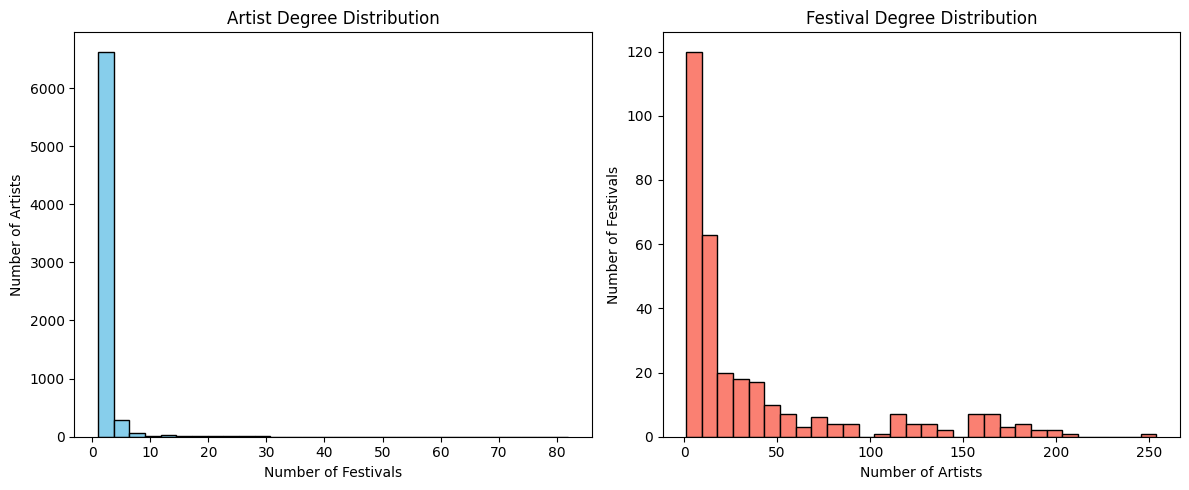

In [115]:
# plot degree distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(artist_degrees, bins=30, color='skyblue', edgecolor='black')
plt.title('Artist Degree Distribution')
plt.xlabel('Number of Festivals')
plt.ylabel('Number of Artists') 
plt.subplot(1, 2, 2)
plt.hist(festival_degrees, bins=30, color='salmon', edgecolor='black')
plt.title('Festival Degree Distribution')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Festivals')
plt.tight_layout()
plt.show()

In [117]:
artist_deg = {n: G.degree(n) for n in artist_nodes}
festival_deg = {n: G.degree(n) for n in festival_nodes}

artist_side = []
festival_side = []

for artist in artist_nodes:
    for festival in G.neighbors(artist):
        artist_side.append(artist_deg[artist])
        festival_side.append(festival_deg[festival])


In [118]:
from scipy.stats import pearsonr

corr, pval = pearsonr(artist_side, festival_side)
print("Cross-partition degree correlation:", corr)


Cross-partition degree correlation: -0.3711114254390805


**Connected components**

In [119]:
components = list(nx.connected_components(G))
print("Number of connected components:", len(components))

Number of connected components: 8


In [120]:
#print each connected component sizes
for i, component in enumerate(components):
    print(f"Component {i+1} size: {len(component)}")

Component 1 size: 7387
Component 2 size: 3
Component 3 size: 2
Component 4 size: 2
Component 5 size: 3
Component 6 size: 2
Component 7 size: 3
Component 8 size: 2


**Components that will be excluded**

In [122]:
# print what is included in components[i] where i goes from 2 to 8.
for i in range(1, 8):
    for node in components[i]:
        print(f"Component {i} includes node:{node}")

Component 1 includes node:copenhagen-jazz-festival-2000
Component 1 includes node:diana-krall
Component 1 includes node:tony-bennett
Component 2 includes node:baryl
Component 2 includes node:copenhagen-jazz-festival-2024
Component 3 includes node:copenhagen-jazz-festival-2006
Component 3 includes node:sérgio-mendes
Component 4 includes node:gwyneth-herbert
Component 4 includes node:copenhagen-jazz-festival-2005
Component 4 includes node:nikolaj-nørlund
Component 5 includes node:groen-koncert-1984
Component 5 includes node:nanna-luders-jensen
Component 6 includes node:groen-koncert-2015
Component 6 includes node:lagsus-with-emil-stabil-cisilia-vild-smith
Component 6 includes node:christopher-singer
Component 7 includes node:lagsus-with-gilli-rapper
Component 7 includes node:groen-koncert-2016


**Analysis of shortest path (from largest component)**

In [123]:
# copy of network and only save largest components
G_orginal = G.copy()
largest_component = max(components, key=len)
G = G_orginal.subgraph(largest_component).copy()

Average shortest path length: 4.552057498424406


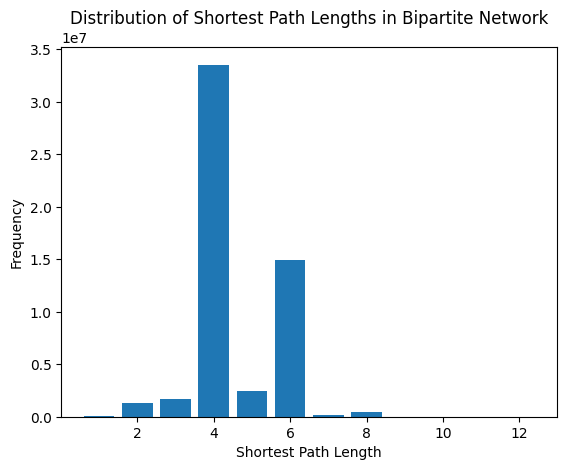

In [125]:
nx.shortest_path_length(G, source=festival_nodes[0])

if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print("Average shortest path length:", avg_path)
else:
    print("Graph is not connected; average shortest path length is undefined.")


# Only works if the graph is connected
if not nx.is_connected(G):
    print("Graph is not fully connected. Using largest connected component.")
    largest_component = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_component)
else:
    G_sub = G

# Calculate all shortest path lengths
path_lengths = dict(nx.all_pairs_shortest_path_length(G_sub))

# Flatten the distances into a single list (excluding 0 self-distances)
all_lengths = []

for source in path_lengths:
    for target in path_lengths[source]:
        if source != target:
            all_lengths.append(path_lengths[source][target])

# Count occurrences of each path length
length_counts = Counter(all_lengths)

# ========================
# PLOT DISTRIBUTION
# ========================

plt.figure()
plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Lengths in Bipartite Network")
plt.show()

**Diameter**

Longest shortest path is 12 steps. Pick the two nodes in your graph that are the farthest apart in terms of graph distance (shortest path length). Between them, the shortest route takes 12 edges

In [126]:
#Network Diameter
diameter = nx.diameter(G_sub)
print("Network Diameter:", diameter)

Network Diameter: 12


**Clustering Coefficient**

In [140]:
from networkx.algorithms import bipartite

clustering_bip = bipartite.clustering(G_sub)
avg_clust_bip = bipartite.average_clustering(G_sub)
print("Average bipartite clustering:", avg_clust_bip)


Average bipartite clustering: 0.5829828806658197


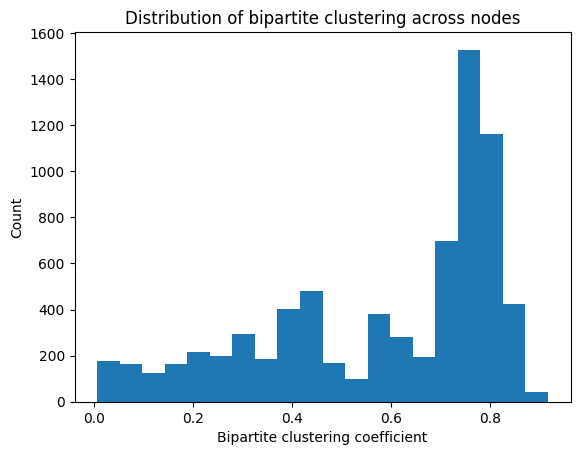

In [141]:
import matplotlib.pyplot as plt

vals = list(clustering_bip.values())

plt.hist(vals, bins=20)
plt.xlabel("Bipartite clustering coefficient")
plt.ylabel("Count")
plt.title("Distribution of bipartite clustering across nodes")
plt.show()


In [ ]:
nx.set_node_attributes(G_sub, clustering_bip, "bip_clustering")


data = []
for n, d in G_sub.nodes(data=True):
    genre = d.get("genre", None)
    coeff = d.get("bip_clustering", None)
    data.append({"node": n, "genre": genre, "coef": coeff})

df = pd.DataFrame(data)
df = df.dropna(subset=["genre", "coef"])


plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="genre", y="coef")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# plot the bipartie averge clustering coefficient per gerne
genre_clust = defaultdict(list)
for node, data in G.nodes(data=True):
    if data.get('bipartite') == 'artist':
        genres = data.get('genres', [])
        clust = clustering_bip[node]
        for genre in genres:
            genre_clust[genre].append(clust)

In [142]:
from networkx.algorithms import bipartite
import pandas as pd

# compute bipartite clustering for every node
degree = dict(G.degree())

# convert to DataFrame for easy sorting
df = pd.DataFrame({
    "node": list(clustering_bip.keys()),
    "clustering": list(clustering_bip.values()),
    "type": ["artist" if n in artist_nodes else "festival" for n in clustering_bip.keys()],
    "count_links": [degree[n] for n in clustering_bip.keys()]

})

# sort separately
top_artists = df[df["type"] == "artist"].sort_values("clustering", ascending=False).head(10)
top_festivals = df[df["type"] == "festival"].sort_values("clustering", ascending=False).head(10)

print("Top 10 artists by bipartite clustering:")
print(top_artists)

print("\nTop 10 festivals by bipartite clustering:")
print(top_festivals)


Top 10 artists by bipartite clustering:
                                  node  clustering    type  count_links
6860                        ed-thigpen    0.916667  artist            1
6861                  jesper-lundgaard    0.916667  artist            1
6855  marie-bergman-&-maj-britt-kramer    0.916667  artist            1
6856                   sidsel-endresen    0.916667  artist            1
6857                       beady-belle    0.916667  artist            1
6859                          andy-bey    0.916667  artist            1
6858                   patricia-barber    0.916667  artist            1
6854                     andy-sheppard    0.916667  artist            1
7379                       the prodigy    0.882732  artist            1
7363                       emeli sandé    0.882732  artist            1

Top 10 festivals by bipartite clustering:
                    node  clustering      type  count_links
6542  nibe-festival-2001     0.22088  festival           11
6556 

### Creation of Projectiled network

In [4]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_network_attributes.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode())

# Convert to NetworkX graph
G= json_graph.node_link_graph(data)
print("Loaded graph with", F.number_of_nodes(), "nodes and", F.number_of_edges(), "edges")


HTTPError: HTTP Error 404: Not Found

In [43]:
# ========== PROJECT TO FESTIVAL-YEAR NETWORK ==========
F = nx.Graph()

# Add festival nodes
for node in festival_nodes:
    F.add_node(node, **G.nodes[node])

shared_artist_count = defaultdict(int)

# Count shared artists
for artist in artist_nodes:
    festivals = list(G.neighbors(artist))
    for i in range(len(festivals)):
        for j in range(i + 1, len(festivals)):
            f1, f2 = festivals[i], festivals[j]
            shared_artist_count[(f1, f2)] += 1

# Add edges with raw weight
for (f1, f2), weight in shared_artist_count.items():
    F.add_edge(f1, f2, weight=weight)

# ========== NORMALISATION (JACCARD SIMILARITY) ==========
for f1, f2 in F.edges():
    artists_f1 = set(G.neighbors(f1))
    artists_f2 = set(G.neighbors(f2))

    intersection = len(artists_f1 & artists_f2)
    union = len(artists_f1 | artists_f2)

    jaccard = intersection / union if union != 0 else 0

    F[f1][f2]['jaccard'] = jaccard


# ========== SAVE PROJECTED NETWORK ==========
projection_data = json_graph.node_link_data(F)

with open("festival_similarity_network.json", "w", encoding="utf-8") as f:
    json.dump(projection_data, f, ensure_ascii=False, indent=2)

print("Saved festival_similarity_network.json")


Saved festival_similarity_network.json


### Analysis of projectiled festival netowrk

In [ ]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_similarity_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode())

# Convert to NetworkX graph
F= json_graph.node_link_graph(data)
print("Loaded graph with", F.number_of_nodes(), "nodes and", F.number_of_edges(), "edges")


**Analysis of jacobi over time per festival**

In [44]:
import itertools
import pandas as pd

# ========================
# GROUP FESTIVAL-YEAR NODES BY FESTIVAL (using attributes)
# ========================

festival_groups = {}

for node, data in F.nodes(data=True):   # Use F for clean festival-year nodes
    festival_name = data["festival"]    # attribute you added earlier
    year = int(data["year"])            # convert to int for sorting

    # Create structure: { festival_name : {year : node } }
    festival_groups.setdefault(festival_name, {})[year] = node


# ========================
# CALCULATE JACCARD OVER TIME
# ========================

overlap_results = []

for festival, years_dict in festival_groups.items():
    
    # Sort years chronologically
    years = sorted(years_dict.keys())
    
    # Compare all year-pairs for that festival
    for y1, y2 in itertools.combinations(years, 2):
        
        node1 = years_dict[y1]
        node2 = years_dict[y2]
        
        artists_1 = set(G.neighbors(node1))
        artists_2 = set(G.neighbors(node2))
        
        intersection = len(artists_1 & artists_2)
        union = len(artists_1 | artists_2)
        
        jaccard = intersection / union if union != 0 else 0
        
        overlap_results.append({
            "festival": festival,
            "year_1": y1,
            "year_2": y2,
            "jaccard_overlap": jaccard,
            "shared_artists": intersection,
            "total_unique_artists": union
        })


# ========================
# TURN INTO DATAFRAME FOR DISPLAY
# ========================

overlap_df = pd.DataFrame(overlap_results)


# ========================
# SHOW MOST & LEAST STABLE FESTIVALS
# ========================

print("\n===== Most Stylistically Stable Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=False)
      .head(10)
      .to_string(index=False))


print("\n===== Most Dramatically Changing Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=True)
      .head(10)
      .to_string(index=False))



===== Most Stylistically Stable Festivals =====
festival  year_1  year_2  jaccard_overlap  shared_artists  total_unique_artists
    nibe    2006    2009              1.0              11                    11
    nibe    2007    2011              1.0              11                    11
    nibe    2007    2020              1.0              11                    11
    nibe    2007    2019              1.0              11                    11
    nibe    2007    2018              1.0              11                    11
    nibe    2007    2017              1.0              11                    11
    nibe    2007    2016              1.0              11                    11
    nibe    2007    2015              1.0              11                    11
    nibe    2007    2014              1.0              11                    11
    nibe    2007    2013              1.0              11                    11

===== Most Dramatically Changing Festivals =====
festival  year_1  yea

**Caluclating modularity**

In [ ]:

communities = louvain_communities(F,seed=0)

# Compute modularity of Louvain partition
M_louvain = modularity(F, communities)

print(f"Louvain modularity: {M_louvain:.4f}")
print(f"Number of detected communities: {len(communities)}")


Louvain modularity: 0.3344
Number of detected communities: 14


**Confusion Matrix**

In [46]:
# Convert communities (list of sets) → node → community ID
comm_dict = {node: i for i, comm in enumerate(communities) for node in comm}

# Build dataframe of (genre, community) for all artist nodes
rows = []

for n in F.nodes:
    genres = F.nodes[n].get("genres", [])
    if not genres:
        continue  # skip nodes without genre info

    community_id = comm_dict.get(n)
    if community_id is None:
        continue

    # since each artist has only ONE genre
    genre = genres[0]

    rows.append((genre, community_id))

df = pd.DataFrame(rows, columns=["genre", "community"])

#  build the confusion matrix 
D = pd.crosstab(df["genre"], df["community"])

# - keep only top 10 genres
top_genres = D.sum(axis=1).sort_values(ascending=False).head(10).index
D_top = D.loc[top_genres]

print("Shape of confusion matrix:", D_top.shape)
display(D_top)


Shape of confusion matrix: (0, 0)


community
genre


**Plotting the communtities**

In [ ]:
# map node -> community id, largest communities first
comms = sorted(communities, key=len, reverse=True)
cid = {n: i for i, C in enumerate(comms) for n in C}
TOP_K = 8

# degree-based sizes (normalized)
deg = np.array([UG.degree(n) for n in UG.nodes()], float)
deg = (deg - deg.min()) / (deg.max() - deg.min() + 1e-9)
sizes = 100 + deg * (2000 - 100)

# ForceAtlas2 layout (NetworkX 3.5)
pos = nx.forceatlas2_layout(UG, max_iter=500)

# colors: top-K use tab10, others light gray
import matplotlib.cm as cm
cmap = cm.get_cmap("tab10", TOP_K)
colors = [cmap(cid[n]) if cid[n] < TOP_K else (0.85, 0.85, 0.85, 0.7) for n in UG.nodes()]

# plot
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx_edges(UG, pos, alpha=0.25, width=0.4, ax=ax)
nx.draw_networkx_nodes(UG, pos, node_size=sizes, node_color=colors, linewidths=0.0, ax=ax)
ax.set_title(f"ForceAtlas2 • Louvain communities • M = {M_louvain:.3f}")
ax.axis("off")
plt.tight_layout()
plt.show()


## Wiki Shit, dont relevent at the moment after spotify api worked

In [ ]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/5a951ece8731d0caa5f6aa481a6d6171ef1a77df/festival_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode())

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)
print("Loaded graph with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

artist_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']



Loaded graph with 7404 nodes and 12095 edges


In [37]:
import requests
import time

UA = "Mozilla/5.0 (student project)"
WIKI_API = "https://en.wikipedia.org/w/api.php"
SPARQL_URL = "https://query.wikidata.org/sparql"

S = requests.Session()
S.headers.update({"User-Agent": UA})

def get_wikidata_qid(name):
    """
    Resolve an artist name to a Wikidata QID via Wikipedia.
    1) Try exact title lookup
    2) If that fails, use search and pick the best hit
    """
    try:
        # Normalise: Wikipedia prefers spaces, not underscores
        name = name.replace("_", " ")

        # 1) Try exact title first
        r = S.get(WIKI_API, params={
            "action": "query",
            "titles": name,
            "redirects": 1,
            "prop": "pageprops",
            "format": "json"
        }, timeout=10)

        pages = r.json()["query"]["pages"]
        page = next(iter(pages.values()))
        qid = page.get("pageprops", {}).get("wikibase_item")

        if qid:
            return qid

        # 2) If no QID, fall back to search
        r = S.get(WIKI_API, params={
            "action": "query",
            "list": "search",
            "srsearch": name,
            "srlimit": 5,
            "format": "json"
        }, timeout=10)

        results = r.json().get("query", {}).get("search", [])
        if not results:
            return None

        # Prefer musician-related pages if possible
        titles = [res["title"] for res in results]

        # Try to prefer titles that look like musicians
        preferred_titles = [
            t for t in titles
            if "(musician" in t.lower()
            or "(singer" in t.lower()
            or "(rapper" in t.lower()
            or "(band" in t.lower()
        ]

        if preferred_titles:
            best_title = preferred_titles[0]
        else:
            best_title = titles[0]

        # 3) Query again with the chosen title to get its QID
        r = S.get(WIKI_API, params={
            "action": "query",
            "titles": best_title,
            "redirects": 1,
            "prop": "pageprops",
            "format": "json"
        }, timeout=10)

        pages = r.json()["query"]["pages"]
        page = next(iter(pages.values()))
        qid = page.get("pageprops", {}).get("wikibase_item")
        return qid

    except Exception as e:
        print(f"QID error for {name}: {e}")
        return None


def get_genres_from_qid(qid):
    """Retrieve 'genre' (P136) from Wikidata."""
    try:
        query = f"""
        SELECT ?genreLabel WHERE {{
          wd:{qid} wdt:P136 ?genre .
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
        }}
        """
        r = S.get(
            SPARQL_URL,
            params={"query": query, "format": "json"},
            headers={"Accept": "application/sparql-results+json"},
            timeout=20
        )

        rows = r.json()["results"]["bindings"]
        return sorted({row["genreLabel"]["value"].lower() for row in rows})
    except:
        return []


In [49]:
missing_genres = 0

for idx, artist in enumerate(artist_nodes, start=1):

    # Replace underscores with spaces for Wikipedia
    query_name = artist.replace("_", " ")

    qid = get_wikidata_qid(query_name)

    if not qid:
        G.nodes[artist]["genres"] = []
        missing_genres += 1
        continue

    genres = get_genres_from_qid(qid)
    G.nodes[artist]["genres"] = genres

    if idx % 50 == 0:
        print(f"Processed {idx}/{len(artist_nodes)} artists")

    time.sleep(0.1)  # avoid hammering Wikidata


Processed 50/7087 artists
Processed 150/7087 artists
Processed 200/7087 artists
Processed 250/7087 artists
Processed 300/7087 artists
Processed 350/7087 artists
Processed 400/7087 artists
Processed 450/7087 artists
Processed 500/7087 artists
Processed 550/7087 artists
Processed 600/7087 artists
Processed 650/7087 artists
Processed 700/7087 artists
Processed 800/7087 artists
Processed 850/7087 artists
Processed 900/7087 artists
Processed 950/7087 artists
Processed 1000/7087 artists
Processed 1050/7087 artists
Processed 1100/7087 artists
Processed 1150/7087 artists
Processed 1200/7087 artists
Processed 1250/7087 artists
Processed 1300/7087 artists
Processed 1350/7087 artists
Processed 1400/7087 artists
Processed 1450/7087 artists
Processed 1500/7087 artists
Processed 1550/7087 artists
Processed 1600/7087 artists
Processed 1650/7087 artists
Processed 1700/7087 artists
Processed 1750/7087 artists
Processed 1850/7087 artists
Processed 1900/7087 artists
Processed 1950/7087 artists
Processed 

In [94]:
print(f"Attached genres to artists. Missing genres for {missing_genres}/{len(artist_nodes)} artists.")


Attached genres to artists. Missing genres for 665/7087 artists.


In [ ]:
def _get_genres_from_specific_wiki(title, lang):
    url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": title,
        "prop": "text",
        "format": "json"
    }

    headers = {"User-Agent": "student-project/1.0"}

    r = requests.get(url, params=params, headers=headers, timeout=20)
    if r.status_code != 200:
        return []

    try:
        html = r.json()["parse"]["text"]["*"]
    except:
        return []

    # Get entire infobox
    infobox = re.search(r'<table class="infobox([^>]*)>(.*?)</table>', html, re.DOTALL)
    if not infobox:
        return []

    infobox_html = infobox.group(0)

    # Match Genre(s) row in English AND Danish (Genre, Genres, Genre(r))
    match = re.search(
        r'<th[^>]*>\s*(?:Genre|Genres|Genreer|Genrer)\s*</th>.*?<td[^>]*>(.*?)</td>',
        infobox_html,
        flags=re.DOTALL | re.IGNORECASE
    )

    if not match:
        return []

    td_html = match.group(1)

    # extract both linked and plain list items
    linked = re.findall(r'<a[^>]*>(.*?)</a>', td_html, re.DOTALL)
    list_items = re.findall(r'<li[^>]*>(.*?)</li>', td_html, re.DOTALL)

    raw_items = linked + list_items

    cleaned = []
    for item in raw_items:
        t = item.strip().lower()

        # remove all HTML tags
        t = re.sub(r'<[^>]+>', '', t).strip()

        # ignore citation junk
        if "cite-bracket" in t:
            continue
        if re.fullmatch(r'\d+', t):
            continue
        if not re.search(r'[a-zæøå]', t):  # allow Danish letters
            continue

        t = t.replace("·", " ").strip()

        if t:
            cleaned.append(t)

    return sorted(set(cleaned))


def get_genres_from_wikipedia(title):
    # Try English Wikipedia first, then Danish Wikipedia
    for lang in ["en", "da"]:
        genres = _get_genres_from_specific_wiki(title, lang)
        if genres:
            return genres
    return []


In [86]:
print(get_genres_from_wikipedia("copenhagen steelband"))


[]


In [151]:
get_genres_from_wikipedia("TV-2 (band)")

['pop rock']

In [95]:
count = 0

for artist in artist_nodes:
    if not G.nodes[artist].get("genres"):
        if artist =="tv-2":
            wiki_name =="TV-2 (band)"
        if artist =="wigwam":
            wiki_name =="Wig Wam"
        else: wiki_name = artist.replace("-", " ")

        # first attempt
        genres = get_genres_from_wikipedia(wiki_name)

        # second attempt if empty
        if not genres:
            alt = f"{wiki_name} (band)"
            genres = get_genres_from_wikipedia(alt)

        # save if we found anything
        if genres:
            G.nodes[artist]["genres"] = genres

        count += 1
        if count % 50 == 0:
            print(f"Processed {count} artists… yes I'm still alive.")


Processed 50 artists… yes I'm still alive.
Processed 100 artists… yes I'm still alive.
Processed 150 artists… yes I'm still alive.
Processed 200 artists… yes I'm still alive.
Processed 250 artists… yes I'm still alive.
Processed 300 artists… yes I'm still alive.
Processed 350 artists… yes I'm still alive.
Processed 400 artists… yes I'm still alive.
Processed 450 artists… yes I'm still alive.
Processed 500 artists… yes I'm still alive.
Processed 550 artists… yes I'm still alive.
Processed 600 artists… yes I'm still alive.
Processed 650 artists… yes I'm still alive.
Processed 700 artists… yes I'm still alive.
Processed 750 artists… yes I'm still alive.
Processed 800 artists… yes I'm still alive.
Processed 850 artists… yes I'm still alive.
Processed 900 artists… yes I'm still alive.
Processed 950 artists… yes I'm still alive.
Processed 1000 artists… yes I'm still alive.
Processed 1050 artists… yes I'm still alive.
Processed 1100 artists… yes I'm still alive.
Processed 1150 artists… yes I'

In [178]:
def find_genres_for_artist(artist, G):
    if artist=="tv-2":
        clean_name ="TV-2 (band)"
    if artist=="l-o-c-":
        clean_name ="L.O.C. (rapper)"
    if artist=="c-v-j-rgensen":
        clean_name ="C.V. Jørgensen"
    else:
        clean_name = artist.replace("-", " ")
    genres = None

    # 1. raw name
    attempts = [clean_name]

    # 2. "(band)"
    attempts.append(f"{clean_name} (band)")

    # 3. capitalized version
    cap = clean_name.title()
    attempts.append(cap)

    # 4–6. singer / rapper / DJ
    attempts.append(f"{cap} (singer)")
    attempts.append(f"{cap} (rapper)")
    attempts.append(f"{cap} (DJ)")
    attempts.append(f"{cap} (Danish band)")
    attempts.append(f"{cap} (band)")
    print(attempts)
    # try each possibility until something works
    for title in attempts:
        genres = get_genres_from_wikipedia(title)
        if genres:
            print(genres)
            break

    # store result if found
    if genres:
        print("found it for", artist, "as", title)
        G.nodes[artist]["genres"] = genres

    return genres


In [179]:
count=0
#print all arstists without a genre assigned and have more than 10 festival appearances
for artist in artist_nodes:
    if not G.nodes[artist].get("genres"):
        degree = G.degree(artist)
        if degree > 10:
           find_genres_for_artist(artist, G)
           count += 1
           if count % 50 == 0:
                print(f"Processed {count} artists… yes I'm still alive.")


['C.V. Jørgensen', 'C.V. Jørgensen (band)', 'C.V. Jørgensen', 'C.V. Jørgensen (singer)', 'C.V. Jørgensen (rapper)', 'C.V. Jørgensen (DJ)', 'C.V. Jørgensen (Danish band)', 'C.V. Jørgensen (band)']
['stig m ller', 'stig m ller (band)', 'Stig M Ller', 'Stig M Ller (singer)', 'Stig M Ller (rapper)', 'Stig M Ller (DJ)', 'Stig M Ller (Danish band)', 'Stig M Ller (band)']
['lars lilholt m band', 'lars lilholt m band (band)', 'Lars Lilholt M Band', 'Lars Lilholt M Band (singer)', 'Lars Lilholt M Band (rapper)', 'Lars Lilholt M Band (DJ)', 'Lars Lilholt M Band (Danish band)', 'Lars Lilholt M Band (band)']
['johnny madsen band', 'johnny madsen band (band)', 'Johnny Madsen Band', 'Johnny Madsen Band (singer)', 'Johnny Madsen Band (rapper)', 'Johnny Madsen Band (DJ)', 'Johnny Madsen Band (Danish band)', 'Johnny Madsen Band (band)']
['aarhus symfoniorkester', 'aarhus symfoniorkester (band)', 'Aarhus Symfoniorkester', 'Aarhus Symfoniorkester (singer)', 'Aarhus Symfoniorkester (rapper)', 'Aarhus Symf

In [192]:
#count how mant artists have genres assigned and how many are missing
with_genres = sum(1 for artist in artist_nodes if G.nodes[artist].get("genres"))
without_genres = len(artist_nodes) - with_genres 
print(f"Artists with genres: {with_genres}, without genres: {without_genres}")

Artists with genres: 3766, without genres: 3321


In [166]:
find_genres_for_artist('l-o-c-', G)

['L.O.C. (rapper)', 'L.O.C. (rapper) (band)', 'L.O.C. (Rapper)', 'L.O.C. (Rapper) (singer)', 'L.O.C. (Rapper) (rapper)', 'L.O.C. (Rapper) (DJ)', 'L.O.C. (Rapper) (Danish band)']
['hip hop', 'rap']
found it for l-o-c- as L.O.C. (rapper)


['hip hop', 'rap']

In [188]:
#print(get_genres_from_wikipedia("Love Shop"))
#G.nodes["love shop"]["genres"] = ["pop rock"]
#G.nodes["danser-med-drenge"]["genres"] = ["soul", "pop", "reggae"]
G.nodes["c-v-j-rgensen"]["genres"] = ["pop", "rock", "folk rock"]
G.nodes["kind-mod-kind"]["genres"] = ["pop"]
G.nodes["aarhus-symfoniorkester"]["genres"] = ["classical"]	
G.nodes["folkeklubben"]["genres"] = ["pop"]
G.nodes["inside the whale"]["genres"] = ["grungy", "funky", "rock"]
G.nodes["the-powls"]["genres"] = ["comody"]
G.nodes["johnny-madsen-band"]["genres"] = ["rock"]

G.nodes["zar-paulo"]["genres"] = ["pop", "rock"]
G.nodes["prisma"]["genres"] = ["alternative", "indie"]


In [149]:
import requests

url = "https://en.wikipedia.org/w/api.php"
params = {
    "action": "parse",
    "page": "Lamin (rapper)",
    "prop": "text",
    "format": "json"
}

headers = {"User-Agent": "student-project/1.0"}

r = requests.get(url, params=params, headers=headers)
print(r.status_code)
print(r.text)
  # Show first 2000 chars


200
{"parse":{"title":"Lamin (rapper)","pageid":81728339,"text":{"*":"<div class=\"mw-content-ltr mw-parser-output\" lang=\"en\" dir=\"ltr\"><div class=\"shortdescription nomobile noexcerpt noprint searchaux\" style=\"display:none\">Danish rapper and songwriter (born 1995)</div>\n<p class=\"mw-empty-elt\">\n</p>\n<style data-mw-deduplicate=\"TemplateStyles:r1126788409\">.mw-parser-output .plainlist ol,.mw-parser-output .plainlist ul{line-height:inherit;list-style:none;margin:0;padding:0}.mw-parser-output .plainlist ol li,.mw-parser-output .plainlist ul li{margin-bottom:0}</style><style data-mw-deduplicate=\"TemplateStyles:r1316064257\">.mw-parser-output .infobox-subbox{padding:0;border:none;margin:-3px;width:auto;min-width:100%;font-size:100%;clear:none;float:none;background-color:transparent;color:inherit}.mw-parser-output .infobox-3cols-child{margin:-3px}.mw-parser-output .infobox .navbar{font-size:100%}@media screen{html.skin-theme-clientpref-night .mw-parser-output .infobox-full-da

In [110]:
name = "tobias rahim"
cap = name.title()
cap

'Tobias Rahim'

In [5]:
[x for x in G.nodes if "lamin" in x.lower()]


NameError: name 'G' is not defined

In [134]:
find_genres_for_artist("Lamin", G)


['Lamin', 'Lamin (band)', 'Lamin', 'Lamin (singer)', 'Lamin (rapper)', 'Lamin (DJ)', 'Lamin (Danish band)']


[]

In [190]:
#print all arstists without a genre assigned and have more than 10 festival appearances
for artist in artist_nodes:
    if not G.nodes[artist].get("genres"):
        degree = G.degree(artist)
        if degree > 10:
            print(f"{artist} - Festivals: {degree}")


stig-m-ller - Festivals: 18
lars-lilholt-m-band - Festivals: 13
allan-olsen - Festivals: 11
peter-de-andre-kopier - Festivals: 11
ary - Festivals: 13
eee-gee - Festivals: 14
stig møller - Festivals: 25
incorrect? - Festivals: 25
api - Festivals: 25
sko/torp - Festivals: 14
benjamin-hav-&-familien - Festivals: 12
lp - Festivals: 12
nxworries-feat.&nbsp;anderson-.paak-&-knxwledge - Festivals: 12


In [60]:
get_wikidata_qid('Cavetown')

'Q64577327'

In [70]:
get_genres_from_qid('Q131783295')

[]

In [4]:
# ========== SAVE Genre NETWORK ==========

# Convert graph to JSON serializable structure
data = json_graph.node_link_data(G)

with open("festival_network.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("Saved 'festival_network_Genre_0312.json'")


NameError: name 'G' is not defined

In [194]:
from collections import Counter

genre_counter = Counter()

for node, data in G.nodes(data=True):
    if data["bipartite"] == "artist" and "genres" in data:
        genres = data["genres"]
        if isinstance(genres, list):
            for g in genres:
                genre_counter[g] += 1
        else:
            genre_counter[genres] += 1

print("\n===== MOST COMMON GENRES IN NETWORK =====")
for genre, count in genre_counter.most_common(20):
    print(f"{genre}: {count}")



===== MOST COMMON GENRES IN NETWORK =====
alternative rock: 397
pop music: 349
rock music: 314
hip-hop: 244
indie rock: 239
jazz: 198
hard rock: 191
punk rock: 153
pop rock: 144
electronic music: 114
soul: 109
blues: 101
electronica: 100
new wave: 94
indie pop: 93
heavy metal: 87
rhythm and blues: 83
progressive rock: 82
reggae: 74
synth-pop: 74


In [88]:
print(artist, G.nodes["gasoline"].get("genres"))


KeyError: 'gasoline'

In [195]:
festival_genre_profiles = {}

for node, data in G.nodes(data=True):
    if data["type"] == "festival_year":
        festival = data["festival"]
        year = data["year"]
        key = f"{festival}_{year}"
        
        genre_counter = Counter()
        artists = G.neighbors(node)
        
        for artist in artists:
            artist_data = G.nodes[artist]
            if "genre" in artist_data:
                genres = artist_data["genre"]
                if isinstance(genres, list):
                    for g in genres:
                        genre_counter[g] += 1
        
        festival_genre_profiles[key] = genre_counter


KeyError: 'type'

In [ ]:
print("\n===== GENRE PROFILE FOR A FESTIVAL-YEAR =====")
print("Roskilde_2022:", festival_genre_profiles.get("Roskilde_2022"))


In [57]:
import math

def shannon_entropy(counter):
    total = sum(counter.values())
    entropy = 0
    for count in counter.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

festival_genre_diversity = {}

for festival, counter in festival_genre_profiles.items():
    festival_genre_diversity[festival] = shannon_entropy(counter)

print("\n===== MOST GENRE-DIVERSE FESTIVALS =====")
for f, v in sorted(festival_genre_diversity.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f, round(v, 3))


NameError: name 'festival_genre_profiles' is not defined

In [151]:
from networkx.algorithms import bipartite
artist_nodes_sub = [n for n, d in G_sub.nodes(data=True) if d.get("bipartite") == "artist"]
festival_nodes_sub = [n for n, d in G_sub.nodes(data=True) if d.get("bipartite") == "festival_year"]

A_proj = bipartite.weighted_projected_graph(G_sub, artist_nodes_sub)
F_proj = bipartite.weighted_projected_graph(G_sub, festival_nodes_sub)


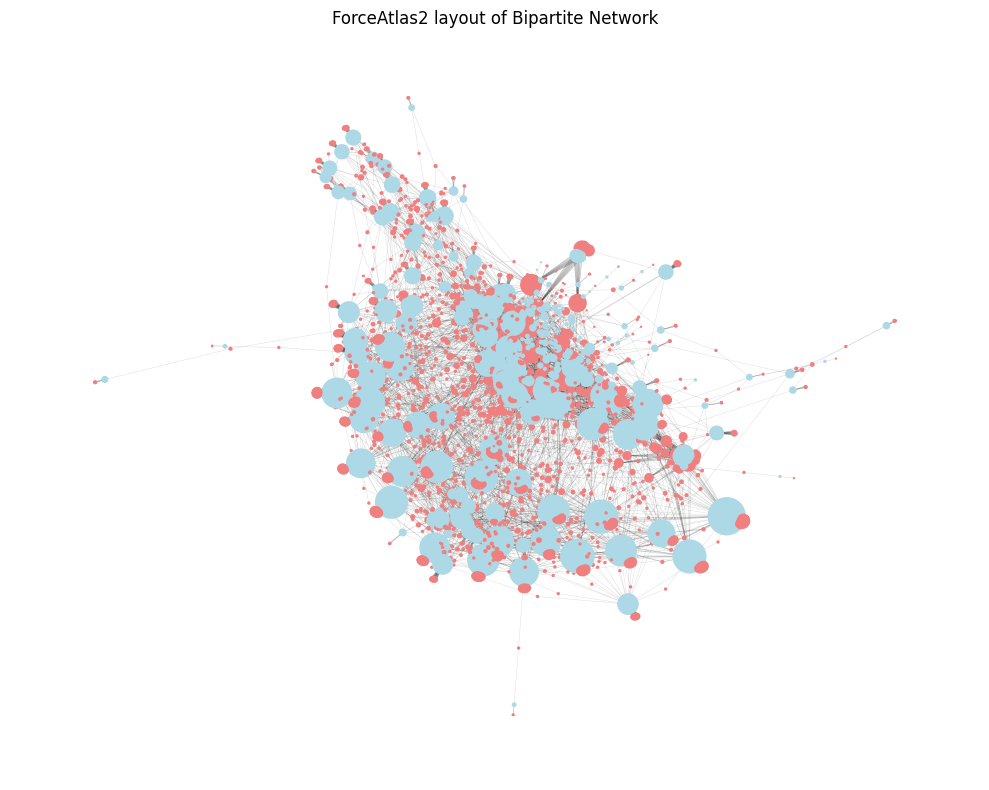

In [153]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Compute ForceAtlas2 layout
pos = nx.forceatlas2_layout(G_sub, max_iter=300)   # you can increase to 500

# Optional: scale node sizes by degree
sizes = [G_sub.degree(n) * 3 for n in G_sub.nodes()]

# Optional: simple coloring by type (artist/festival)
colors = [
    "lightcoral" if n in artist_nodes_sub else "lightblue"
    for n in G_sub.nodes()
]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(G_sub, pos, node_size=sizes, node_color=colors, linewidths=0)
plt.title("ForceAtlas2 layout of Bipartite Network")
plt.axis("off")
plt.tight_layout()
plt.show()


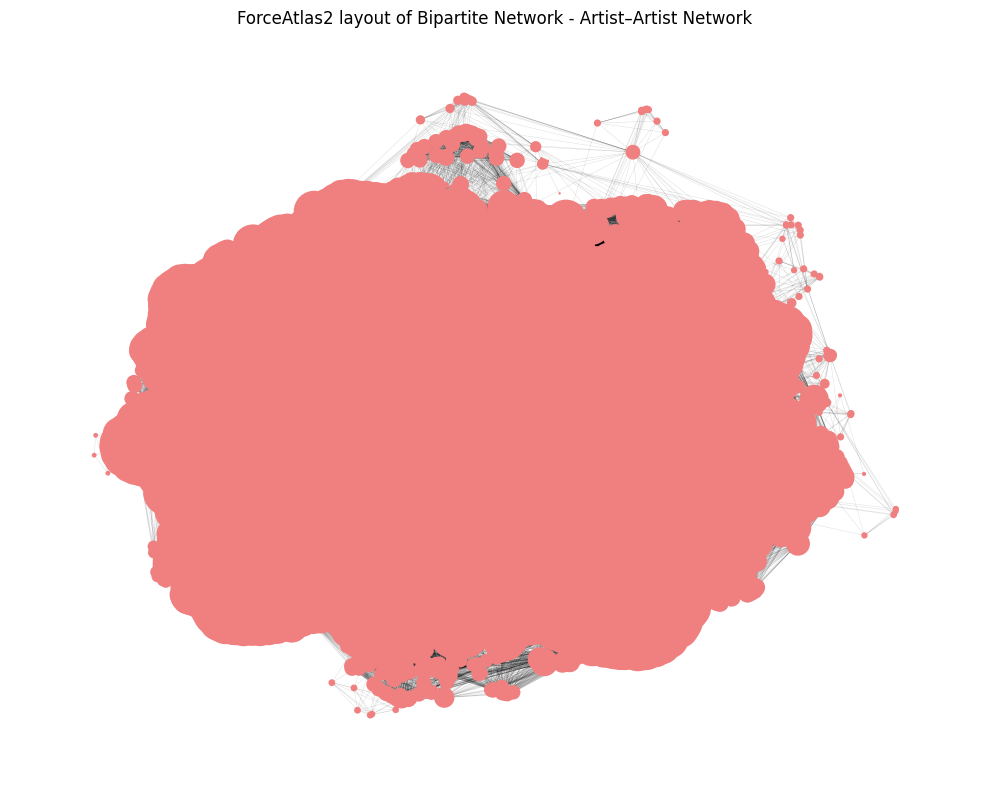

In [156]:
pos_A = nx.forceatlas2_layout(A_proj, max_iter=300)
# Optional: scale node sizes by degree
sizes = [A_proj.degree(n) * 3 for n in A_proj.nodes()]

# Optional: simple coloring by type (artist/festival)
colors = [
    "lightcoral" if n in artist_nodes_sub else "lightblue"
    for n in A_proj.nodes()
]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(A_proj, pos_A, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(A_proj, pos_A, node_size=sizes, node_color=colors, linewidths=0)
plt.title("ForceAtlas2 layout of Bipartite Network - Artist–Artist Network")
plt.axis("off")
plt.tight_layout()
plt.show()

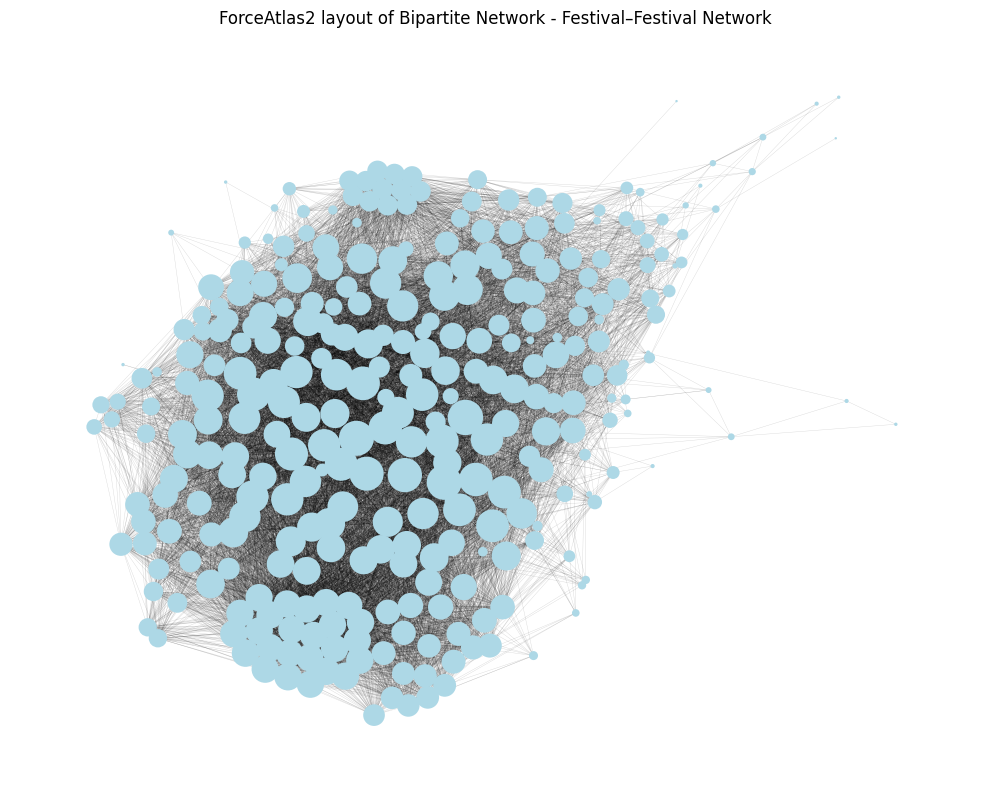

In [157]:
pos_F = nx.forceatlas2_layout(F_proj, max_iter=300)
# Optional: scale node sizes by degree
sizes = [F_proj.degree(n) * 3 for n in F_proj.nodes()]

# Optional: simple coloring by type (artist/festival)
colors = [
    "lightcoral" if n in artist_nodes_sub else "lightblue"
    for n in F_proj.nodes()
]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(F_proj, pos_F, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(F_proj, pos_F, node_size=sizes, node_color=colors, linewidths=0)
plt.title("ForceAtlas2 layout of Bipartite Network - Festival–Festival Network")
plt.axis("off")
plt.tight_layout()
plt.show()